In [3]:
!pip install ultralytics opencv-python numpy


  Using cached opencv_python-4.13.0.90-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl.metadata (60 kB)
Using cached opencv_python-4.13.0.90-cp37-abi3-win_amd64.whl (40.2 MB)
Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl (12.9 MB)

  Attempting uninstall: numpy

    Found existing installation: numpy 1.26.4

   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   --------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
roboflow 1.2.13 requires opencv-python-headless==4.10.0.84, which is not installed.
easyocr 1.7.2 requires opencv-python-headless, which is not installed.


In [21]:
# Importing Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

from ultralytics import YOLO
from sklearn.cluster import KMeans

import pytesseract


Text(0.5, 1.0, 'Sample Frame from Match Footage')

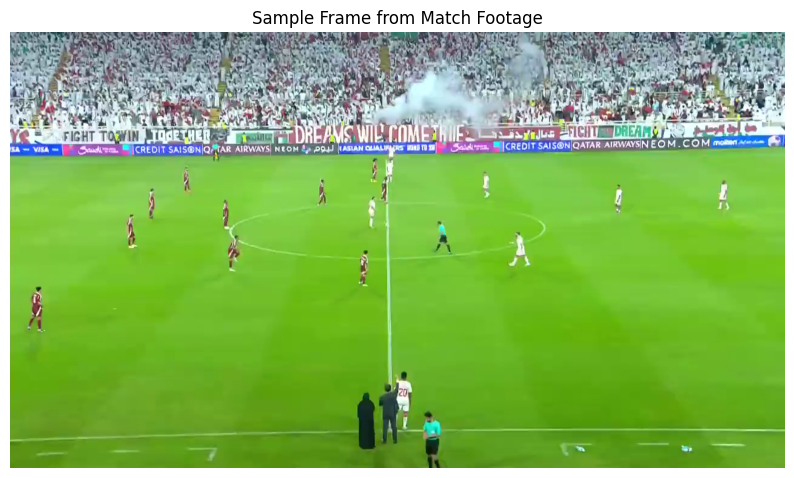

In [10]:
# Video Path and Showing a Sample Frame from the Match
video_path = r"C:\Users\shady\Downloads\CV_Task.mkv"

cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Sample Frame from Match Footage")


In [41]:
# Loading the Model
model = YOLO("yolov8x.pt")

In [42]:
# Extracting The Jersey's Color
def extract_jersey_color(player_crop):
    h, w, _ = player_crop.shape
    upper = player_crop[int(0.2*h):int(0.6*h), int(0.2*w):int(0.8*w)]
    if upper.size == 0:
        return None
    hsv = cv2.cvtColor(upper, cv2.COLOR_BGR2HSV)
    return hsv.reshape(-1,3).mean(axis=0)


In [47]:
# ---------------- OCR-based jersey number recognition ----------------
def recognize_jersey_number_ocr(player_crop):
    gray = cv2.cvtColor(player_crop, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    _, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)

    text = pytesseract.image_to_string(
        thresh,
        config="--psm 7 -c tessedit_char_whitelist=0123456789"
    )
    return text.strip()


# ---------------- Placeholder for YOLO digit detector ----------------
digit_model = None  # e.g., YOLO("jersey_digits.pt")


# ---------------- Hybrid jersey number recognition ----------------
def recognize_jersey_number(player_crop):
    """
    Hybrid jersey number recognition:
    - YOLO digit detector (preferred, if available)
    - Fallback to OCR if digit_model is None
    """
    if digit_model is not None:
        # Example YOLO digit detection (to be implemented when digit model is available)
        # digits = digit_model(player_crop)
        # parsed_number = parse_digits_from_results(digits)
        # return parsed_number
        return None  # placeholder for now

    # Fallback to OCR
    return recognize_jersey_number_ocr(player_crop)


In [43]:
#Reading video metadata
cap = cv2.VideoCapture(video_path)

frame_width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps          = cap.get(cv2.CAP_PROP_FPS)

cap.release()


In [44]:
# Collecting jersey colors
cap = cv2.VideoCapture(video_path)

jersey_colors = []
max_frames = 300
frame_id = 0

while cap.isOpened() and frame_id < max_frames:
    ret, frame = cap.read()
    if not ret:
        break

    frame_id += 1

    results = model(frame, imgsz=640, conf=0.25, verbose=False)

    if results[0].boxes is None:
        continue

    for box, cls in zip(results[0].boxes.xyxy, results[0].boxes.cls):
        label = model.names[int(cls)]
        if label != "person":
            continue

        x1, y1, x2, y2 = map(int, box)
        crop = frame[y1:y2, x1:x2]
        if crop.size == 0:
            continue

        color = extract_jersey_color(crop)
        if color is not None:
            jersey_colors.append(color)

cap.release()

jersey_colors = np.array(jersey_colors)
print("Collected colors:", len(jersey_colors))


Collected colors: 4869


In [45]:
# Putting the Team into 2 Clusters
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(jersey_colors)

means = [jersey_colors[labels==i][:,1].mean() for i in range(2)]

TEAM_UAE   = int(np.argmin(means))  # white → low saturation
TEAM_QATAR = int(np.argmax(means))  # burgundy → high saturation

TEAM_MAP = {
    TEAM_UAE: "UAE",
    TEAM_QATAR: "Qatar"
}

print("Team map:", TEAM_MAP)


Team map: {1: 'UAE', 0: 'Qatar'}


In [48]:
# Video Rendering

cap = cv2.VideoCapture(video_path)

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(
    "final_annotated_output.mp4",
    fourcc,
    fps,
    (frame_width, frame_height)
)

frame_skip = 2   # process every 2nd frame for speed
frame_id = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_id += 1
    if frame_id % frame_skip != 0:
        continue

    results = model(frame, imgsz=640, conf=0.25, verbose=False)

    if results[0].boxes is None:
        out.write(frame)
        continue

    boxes = results[0].boxes.xyxy.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy()

    for box, cls in zip(boxes, classes):
        x1, y1, x2, y2 = map(int, box)
        label = model.names[int(cls)]

        # -------- BALL --------
        if label == "sports ball":
            cx, cy = (x1+x2)//2, (y1+y2)//2
            cv2.circle(frame, (cx, cy), 6, (0,255,255), -1)
            cv2.putText(frame, "Ball", (cx+5, cy+5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,255), 1)
            continue

        # -------- REFEREE --------
        if label == "referee":
            cv2.rectangle(frame, (x1,y1), (x2,y2), (255,200,0), 2)
            cv2.putText(frame, "Referee", (x1, y1-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,200,0), 2)
            continue

        # -------- PLAYER (UAE / QATAR) --------
        if label == "person":
            crop = frame[y1:y2, x1:x2]
            if crop.size == 0:
                continue

            # --- Ignore coaches / staff ---
            box_height = y2 - y1
            box_width  = x2 - x1
            if box_height < frame_height*0.05 or y1 < frame_height*0.05 or y2 > frame_height*0.95:
                continue  # skip likely non-player

            color = extract_jersey_color(crop)
            if color is None or np.isnan(color).any():
                continue

            cluster = int(kmeans.predict(color.reshape(1,-1))[0])
            team = TEAM_MAP.get(cluster, "Unknown")
            box_color = (255,255,255) if team=="UAE" else (0,0,128)

            # --- Jersey number (OCR fallback, fast) ---
            jersey_number = recognize_jersey_number(crop)
            text = f"{team} #{jersey_number}" if jersey_number else team

            cv2.rectangle(frame, (x1,y1), (x2,y2), box_color, 2)
            cv2.putText(frame, text, (x1, y1-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, box_color, 2)
            continue

    out.write(frame)

cap.release()
out.release()
print("final_annotated_output.mp4")


final_annotated_output.mp4 created with:
